<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw3_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw3_data.zip
!mkdir deepul/homeworks/hw3
!mkdir deepul/homeworks/hw3/data
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 71 (delta 13), reused 54 (delta 10), pack-reused 3
Receiving objects: 100% (71/71), 50.91 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (13/13), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0   101M      0  0:00:02  0:00:02 --:--:--  101M
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=12109 sha256=2bdedce728dd76feee779a26cbe4c58dc0cbc591cb3ed9ed405c0c9194466245
  Stored in directory: /tmp/pip-ephem-wheel-cache-rk0cvrvt/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul


In [2]:
from deepul.utils import *


def plot_vae_training_plot(train_losses, test_losses, title, fname):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    savefig(fname)


def sample_data_1_a(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


def sample_data_2_a(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + (rand.randn(count, 2) * [[1.0, 5.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


def sample_data_1_b(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2_b(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + rand.randn(count, 2) * [[1.0, 5.0]]


def q1_sample_data(part, dset_id):
    assert dset_id in [1, 2]
    assert part in ['a', 'b']
    if part == 'a':
        if dset_id == 1:
            dset_fn = sample_data_1_a
        else:
            dset_fn = sample_data_2_a
    else:
        if dset_id == 1:
            dset_fn = sample_data_1_b
        else:
            dset_fn = sample_data_2_b

    train_data, test_data = dset_fn(10000), dset_fn(2500)
    return train_data.astype('float32'), test_data.astype('float32')


def visualize_q1_data(part, dset_id):
    train_data, test_data = q1_sample_data(part, dset_id)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Train Data')
    ax1.scatter(train_data[:, 0], train_data[:, 1])
    ax2.set_title('Test Data')
    ax2.scatter(test_data[:, 0], test_data[:, 1])
    print(f'Dataset {dset_id}')
    plt.show()


def q1_save_results(part, dset_id, fn):
    train_data, test_data = q1_sample_data(part, dset_id)
    train_losses, test_losses, samples_noise, samples_nonoise = fn(train_data, test_data, part, dset_id)
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')

    plot_vae_training_plot(train_losses, test_losses, f'Q1({part}) Dataset {dset_id} Train Plot',
                           f'results/q1_{part}_dset{dset_id}_train_plot.png')
    save_scatter_2d(samples_noise, title='Samples with Decoder Noise',
                    fname=f'results/q1_{part}_dset{dset_id}_sample_with_noise.png')
    save_scatter_2d(samples_nonoise, title='Samples without Decoder Noise',
                    fname=f'results/q1_{part}_dset{dset_id}_sample_without_noise.png')


def visualize_colored_shapes():
    data_dir = get_data_dir(3)
    train_data, test_data = load_pickled_data(join(data_dir, 'shapes_colored.pkl'))
    idxs = np.random.choice(len(train_data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title='Colored Shapes Samples')


def visualize_svhn():
    data_dir = get_data_dir(3)
    train_data, test_data = load_pickled_data(join(data_dir, 'svhn.pkl'))
    idxs = np.random.choice(len(train_data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title='SVHN Samples')


def visualize_cifar10():
    data_dir = get_data_dir(3)
    train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))
    idxs = np.random.choice(len(train_data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title='CIFAR10 Samples')


def q2_save_results(part, dset_id, fn):
    assert part in ['a', 'b'] and dset_id in [1, 2]
    data_dir = get_data_dir(3)
    if dset_id == 1:
        train_data, test_data = load_pickled_data(join(data_dir, 'svhn.pkl'))
    else:
        train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))

    train_losses, test_losses, samples, reconstructions, interpolations = fn(train_data, test_data, dset_id)
    samples, reconstructions, interpolations = samples.astype('float32'), reconstructions.astype('float32'), interpolations.astype('float32')
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')
    plot_vae_training_plot(train_losses, test_losses, f'Q2({part}) Dataset {dset_id} Train Plot',
                           f'results/q2_{part}_dset{dset_id}_train_plot.png')
    show_samples(samples, title=f'Q2({part}) Dataset {dset_id} Samples',
                 fname=f'results/q2_{part}_dset{dset_id}_samples.png')
    show_samples(reconstructions, title=f'Q2({part}) Dataset {dset_id} Reconstructions',
                 fname=f'results/q2_{part}_dset{dset_id}_reconstructions.png')
    show_samples(interpolations, title=f'Q2({part}) Dataset {dset_id} Interpolations',
                 fname=f'results/q2_{part}_dset{dset_id}_interpolations.png')


def q3_save_results(dset_id, fn):
    assert dset_id in [1, 2]
    data_dir = get_data_dir(3)
    if dset_id == 1:
        train_data, test_data = load_pickled_data(join(data_dir, 'svhn.pkl'))
    else:
        train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))

    vqvae_train_losses, vqvae_test_losses, pixelcnn_train_losses, pixelcnn_test_losses, samples, reconstructions = fn(train_data, test_data, dset_id)
    samples, reconstructions = samples.astype('float32'), reconstructions.astype('float32')
    print(f'VQ-VAE Final Test Loss: {vqvae_test_losses[-1]:.4f}')
    print(f'PixelCNN Prior Final Test Loss: {pixelcnn_test_losses[-1]:.4f}')
    save_training_plot(vqvae_train_losses, vqvae_test_losses,f'Q3 Dataset {dset_id} VQ-VAE Train Plot',
                       f'results/q3_dset{dset_id}_vqvae_train_plot.png')
    save_training_plot(pixelcnn_train_losses, pixelcnn_test_losses,f'Q3 Dataset {dset_id} PixelCNN Prior Train Plot',
                       f'results/q3_dset{dset_id}_pixelcnn_train_plot.png')
    show_samples(samples, title=f'Q3 Dataset {dset_id} Samples',
                 fname=f'results/q3_dset{dset_id}_samples.png')
    show_samples(reconstructions, title=f'Q3 Dataset {dset_id} Reconstructions',
                 fname=f'results/q3_dset{dset_id}_reconstructions.png')


def q4_a_save_results(dset_id, fn):
    assert dset_id in [1, 2]
    data_dir = get_data_dir(3)
    if dset_id == 1:
        train_data, test_data = load_pickled_data(join(data_dir, 'svhn.pkl'))
    else:
        train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))

    vqvae_train_losses, vqvae_test_losses, pixelcnn_train_losses, pixelcnn_test_losses, samples, reconstructions = fn(train_data, test_data, dset_id)
    samples, reconstructions = samples.astype('float32'), reconstructions.astype('float32')
    print(f'VQ-VAE Final Test Loss: {vqvae_test_losses[-1]:.4f}')
    print(f'PixelCNN Prior Final Test Loss: {pixelcnn_test_losses[-1]:.4f}')
    save_training_plot(vqvae_train_losses, vqvae_test_losses,f'Q4(a) Dataset {dset_id} VQ-VAE Train Plot',
                       f'results/q4_a_dset{dset_id}_vqvae_train_plot.png')
    save_training_plot(pixelcnn_train_losses, pixelcnn_test_losses,f'Q4(a) Dataset {dset_id} PixelCNN Prior Train Plot',
                       f'results/q4_a_dset{dset_id}_pixelcnn_train_plot.png')
    show_samples(samples, title=f'Q4(a) Dataset {dset_id} Samples',
                 fname=f'results/q4_a_dset{dset_id}_samples.png')
    show_samples(reconstructions, title=f'Q4(a) Dataset {dset_id} Reconstructions',
                 fname=f'results/q4_a_dset{dset_id}_reconstructions.png')


def q4_b_save_results(fn):
    part = 'b'
    data_dir = get_data_dir(3)
    train_data, test_data = load_pickled_data(join(data_dir, 'mnist.pkl'))

    train_losses, test_losses, samples, reconstructions = fn(train_data, test_data)
    samples, reconstructions = samples.astype('float32') * 255, reconstructions.astype('float32') * 255
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')
    plot_vae_training_plot(train_losses, test_losses, f'Q4({part}) Train Plot',
                           f'results/q4_{part}_train_plot.png')
    show_samples(samples, title=f'Q4({part}) Samples',
                 fname=f'results/q4_{part}_samples.png')
    show_samples(reconstructions, title=f'Q4({part}) Reconstructions',
                 fname=f'results/q4_{part}_reconstructions.png')

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


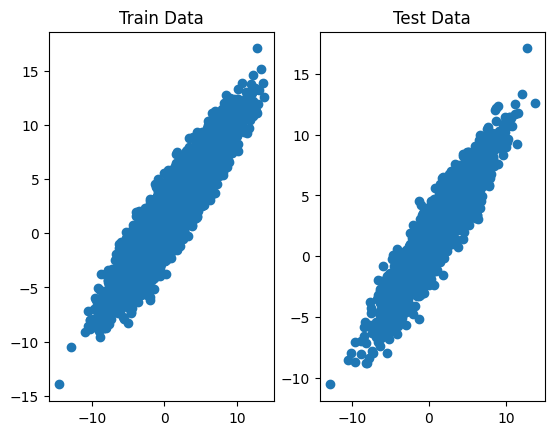

Dataset 2


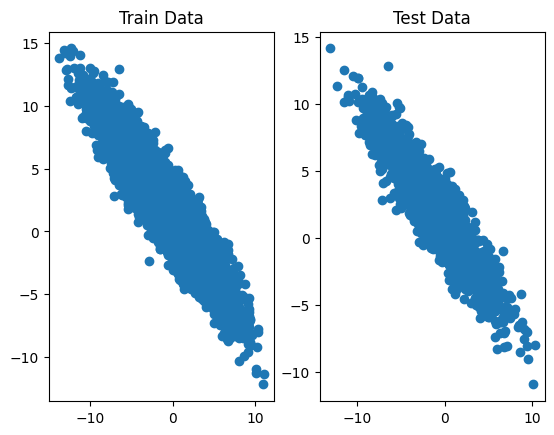

In [ ]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [3]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim


def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip)
        test_loss = eval_loss(model, test_loader, quiet)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses


class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()

        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        model = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.net(x).view(b, *self.output_shape)


class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hidden_sizes=[],
                 dec_hidden_sizes=[]):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLP(input_dim, 2 * latent_dim, enc_hidden_sizes)
        self.decoder = MLP(latent_dim, 2 * input_dim, dec_hidden_sizes)

    def loss(self, x):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        # Compute reconstruction loss - Note that it may be easier for you
        # to use torch.distributions.normal to compute the log_prob
        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
        recon_loss = recon_loss.sum(1).mean()

        # Compute KL
        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()

In [ ]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """

    model = FullyConnectedVAE(2, 2, [128, 128], [128, 128]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=10, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 4.4477, Recon Loss: 2.8659, KL Loss: 1.5818


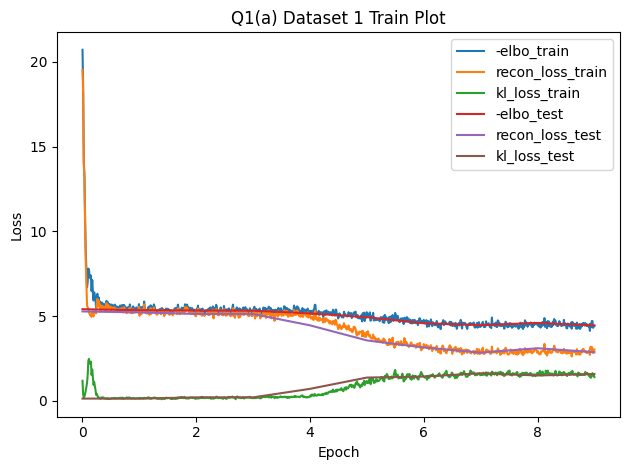

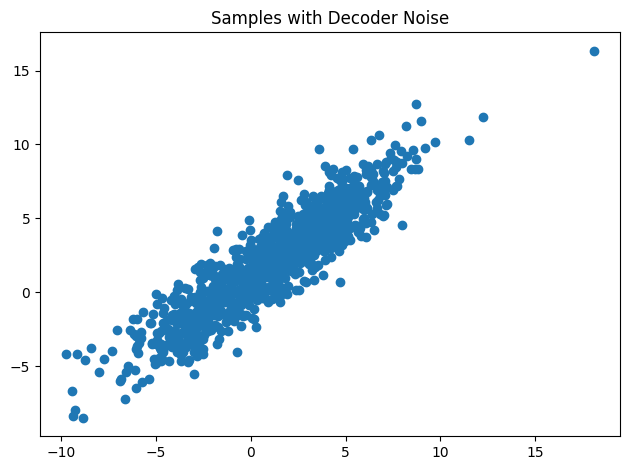

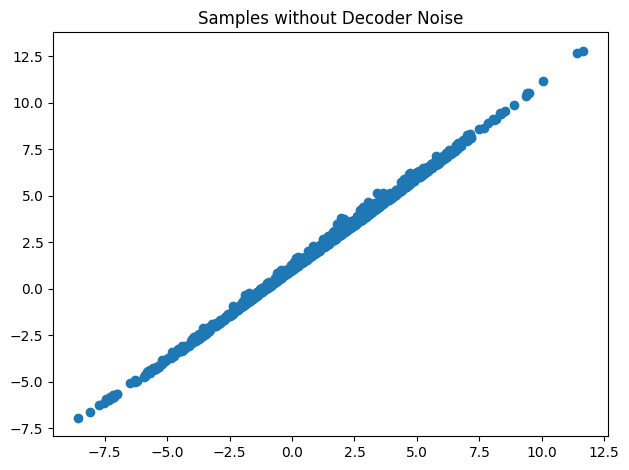

In [ ]:
q1_save_results('a', 1, q1)

Final -ELBO: 4.6145, Recon Loss: 3.0694, KL Loss: 1.5451


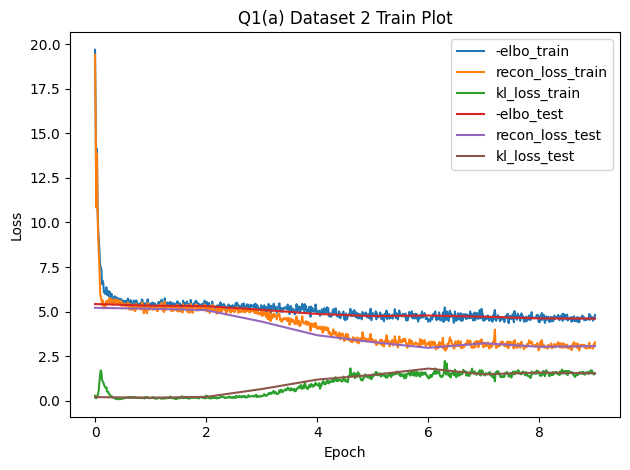

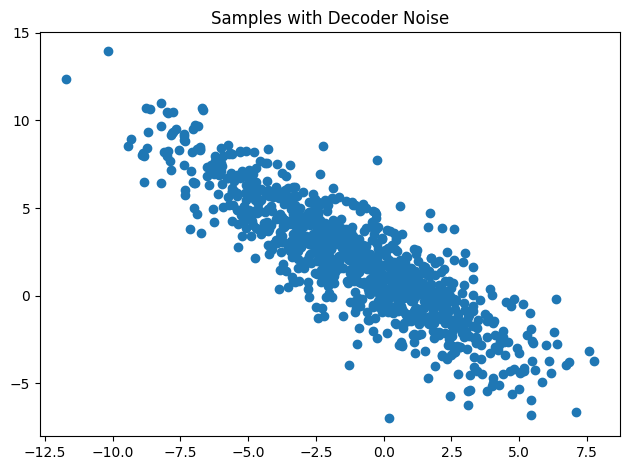

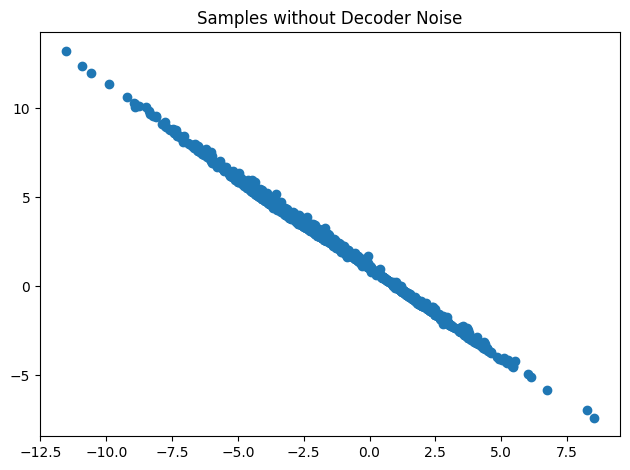

In [ ]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


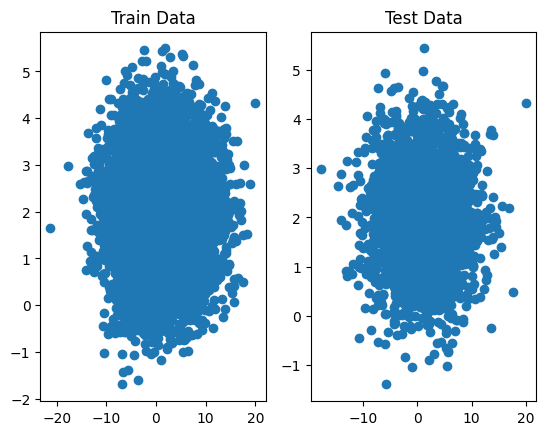

Dataset 2


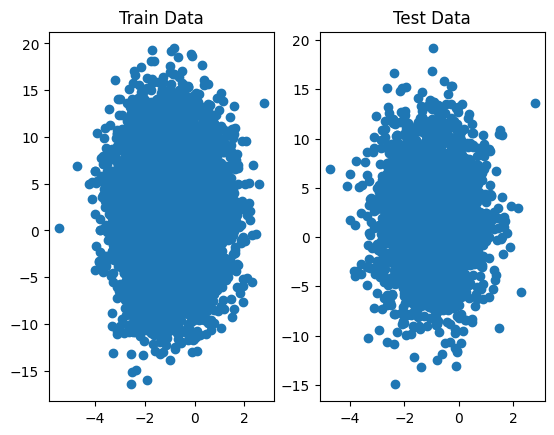

In [ ]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Final -ELBO: 4.4260, Recon Loss: 4.4175, KL Loss: 0.0086


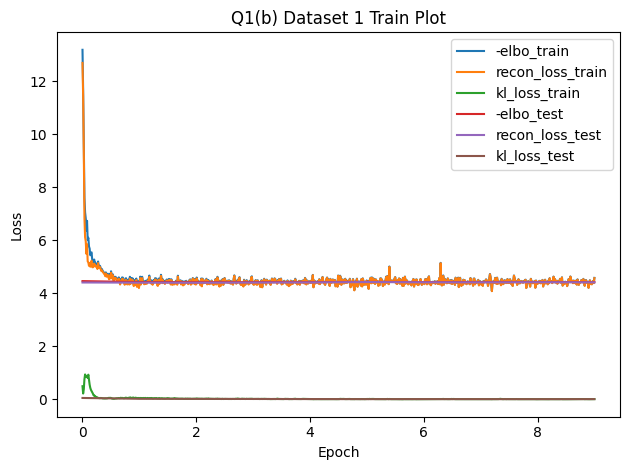

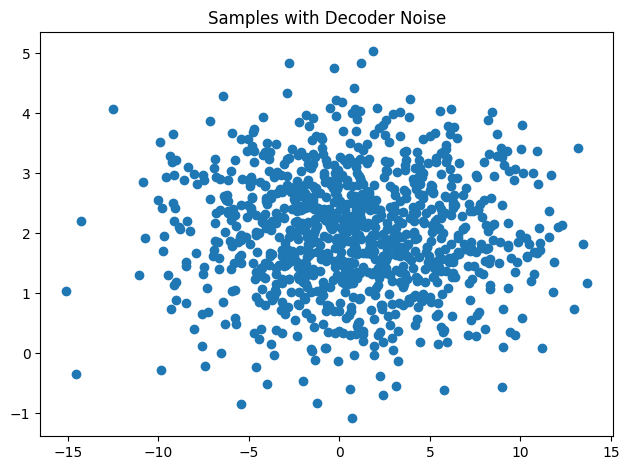

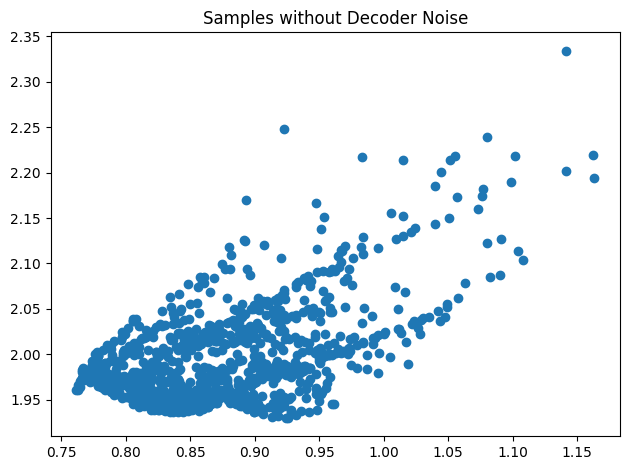

In [ ]:
q1_save_results('b', 1, q1)

Final -ELBO: 4.4199, Recon Loss: 4.4158, KL Loss: 0.0040


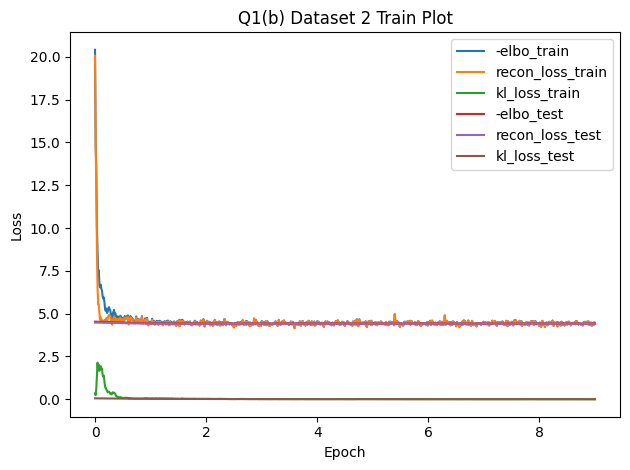

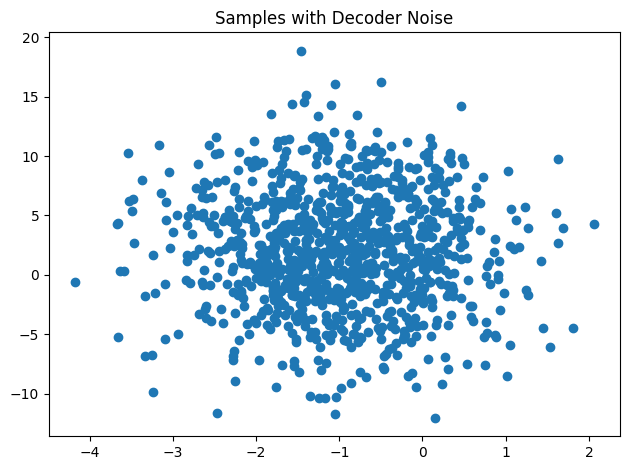

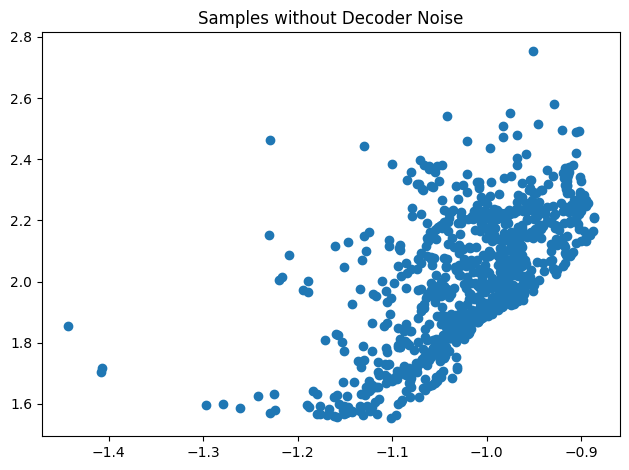

In [ ]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

Answer: The latents are being used in part (a), but not in part (b). This is because the dataset in part (a) comes from a diagonal gaussian distribution so the decoder (also diagonal gaussian) can optimally model the data without the encoder / latents. However, for (a), the data come from a multivariate gaussian with non-diagonal covariance, so the encoder is used to achieve a better loss than without.

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

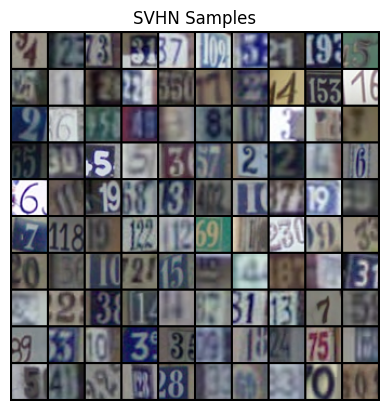

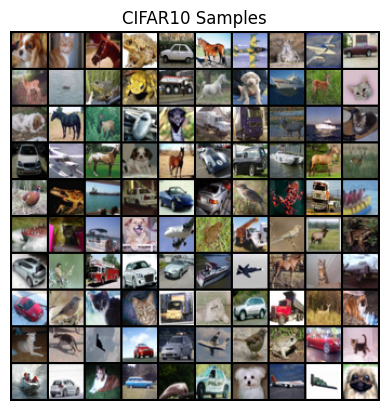

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [4]:
import torch.nn.functional as F

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(latent_dim, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        out = self.deconvs(out)
        return out


class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std


class ConvVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)

    def loss(self, x):
        x = 2 * x - 1
        mu, log_std = self.encoder(x)
        z = torch.randn_like(mu) * log_std.exp() + mu
        x_recon = self.decoder(z)

        recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            samples = torch.clamp(self.decoder(z), -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = ConvVAE((3, 32, 32), 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255.

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Final -ELBO: 103.0603, Recon Loss: 78.6453, KL Loss: 24.4150


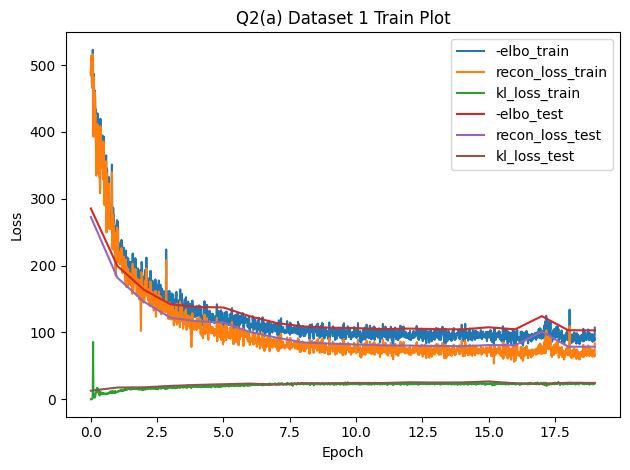

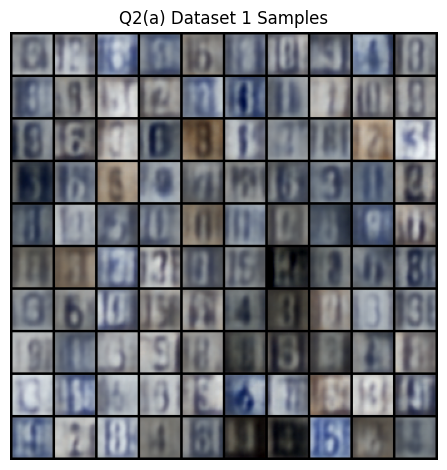

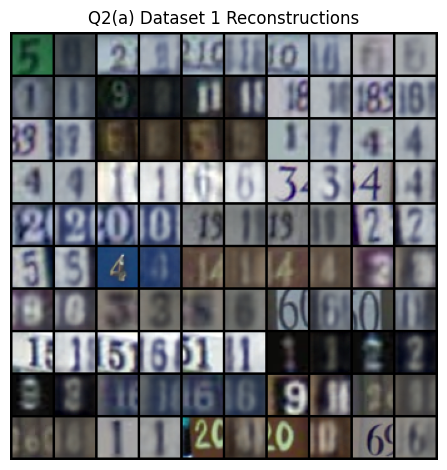

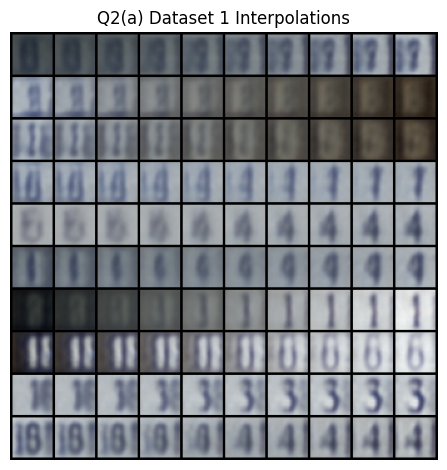

In [ ]:
q2_save_results('a', 1, q2_a)

In [ ]:
q2_save_results('a', 2, q2_a)

KeyboardInterrupt: 

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is an 8x8x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is an 8x8x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [88]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
        )

    def forward(self, z):
        out = self.deconvs(z)
        return out


class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
            LayerNorm(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 2]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 4]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
        )

    def forward(self, x, z_prev):
        z_prev_upscale = F.upsample(z_prev, scale_factor=16)
        x_and_z = torch.cat([x, z_prev_upscale], dim=1)
        out = self.convs(x_and_z)
        mu, log_std = out.chunk(2, dim=1)
        return mu, log_std


class HVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.z1_shape = [8, 4, 4]
        self.z2_shape = [8, 16, 16]

        self.prior1 = None # Unit Gaussian
        self.prior2 = ConvEncoder() # p(z2|z1)

        self.encoder1 = ConvEncoder() # residual p(z1|x)
        self.encoder2 = ConvEncoder() # residual p(z2|z1, x)

        self.decoder = ConvDecoder() # p(x | z2)

    def loss(self, x):
        x = 2 * x.float() - 1

        x0 = torch.zeros_like(x).cuda()
        z0 = torch.zeros((x.shape[0], 12, 2, 2)).cuda()

        z1_mu, z1_logstd = self.encoder1(x, z0)
        z1 = torch.randn_like(z1_mu).cuda() * z1_logstd.exp() + z1_mu

        z2_prior_mu, z2_prior_logstd = self.prior2(x0, z1)
        z2_prior_logstd = z2_prior_logstd * 0
        z2_residual_mu, z2_residual_logstd = self.encoder2(x, z1)
        z2 = torch.randn_like(z0).cuda() * (z2_prior_logstd.exp() * z2_residual_logstd.exp()) + (z2_prior_mu + z2_residual_mu)

        x_recon = self.decoder(z2)

        recon_loss = F.mse_loss(x_recon, x, reduction='none').view(x.shape[0], -1).sum(1).mean()

        kl_z1 = -z1_logstd - 0.5 + (torch.exp(2 * z1_logstd) + z1_mu ** 2) * 0.5
        kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5
        kl_loss = (kl_z1 + kl_z2).sum(1).sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z0 = torch.zeros((n, 12, 2, 2)).cuda()
            z1 = torch.randn(n, 12, 2, 2).cuda()
            x0 = torch.zeros((n, 3, 32, 32)).cuda()

            z2_prior_mu, z2_prior_logstd = self.prior2(x0, z1)
            z2_prior_logstd = z2_prior_logstd * 0

            z2 = torch.randn_like(z0).cuda() * (z2_prior_logstd.exp()) + (z2_prior_mu)
            samples = torch.clamp(self.decoder(z2), -1, 1)
            # samples = torch.clamp(self.decoder(z1), -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

In [91]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = HVAE().cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=10, lr=1e-3), quiet=False)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x0 = torch.zeros_like(x).cuda()
        z0 = torch.zeros((x.shape[0], 12, 2, 2)).cuda()
        x = 2 * x.float() - 1

        z1_mu, z1_logstd = model.encoder1(x, z0)
        z1 = torch.randn_like(z1_mu).cuda() * z1_logstd.exp() + z1_mu

        z2_prior_mu, z2_prior_logstd = model.prior2(x0, z1)
        z2_prior_logstd = z2_prior_logstd * 0
        z2_residual_mu, z2_residual_logstd = model.encoder2(x, z1)
        z2 = torch.randn_like(z0).cuda() * (z2_prior_logstd.exp() * z2_residual_logstd.exp()) + (z2_prior_mu + z2_residual_mu)

        x_recon = model.decoder(z2).clamp(-1, 1)

    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1

        z0 = torch.zeros((x.shape[0], 12, 2, 2)).cuda()
        x0 = torch.zeros_like(x).cuda()
        z1_mu, z1_logstd = model.encoder1(x, z0)
        z1 = torch.randn_like(z1_mu).cuda() * z1_logstd.exp() + z1_mu

        z2_prior_mu, z2_prior_logstd = model.prior2(x0, z1)
        z2_prior_logstd = z2_prior_logstd * 0
        z2_residual_mu, z2_residual_logstd = model.encoder2(x, z1)
        z = (z2_prior_mu + z2_residual_mu)

        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    samples, reconstructions, interps = np.clip(samples, 0, 255), np.clip(reconstructions, 0, 255), np.clip(interps, 0, 255)

    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.


  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 0, loss 527.3802, recon_loss 514.6924, kl_loss 12.6879:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 0, loss 521.2925, recon_loss 511.6441, kl_loss 9.6485:   1%|▏         | 128/10000 [00:00<00:14, 660.85it/s]
Epoch 0, loss 521.2925, recon_loss 511.6441, kl_loss 9.6485:   3%|▎         | 256/10000 [00:00<00:07, 1292.54it/s]
Epoch 0, loss 522.9686, recon_loss 515.4636, kl_loss 7.5051:   3%|▎         | 256/10000 [00:00<00:07, 1292.54it/s]
Epoch 0, loss 523.8472, recon_loss 517.7526, kl_loss 6.0946:   4%|▍         | 384/10000 [00:00<00:07, 1292.54it/s]
Epoch 0, loss 523.8472, recon_loss 517.7526, kl_loss 6.0946:   5%|▌         | 512/10000 [00:00<00:06, 1473.41it/s]
Epoch 0, loss 527.2520, recon_loss 522.1093, kl_loss 5.1427:   5%|▌         | 512/10000 [00:00<00:06, 1473.41it/s]
Epoch 0, loss 525.2943, recon_loss 520.8572, kl_loss 4.4370:   6%|▋         | 640/10000 [00:00<00:06, 1473.41it/s]
Epoch 0, loss 525.2943, recon_loss 520.8572, kl_l

Test , loss 616.1784, recon_loss 616.1757, kl_loss 0.0027



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 1, loss 438.8307, recon_loss 438.8284, kl_loss 0.0024:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 1, loss 482.3248, recon_loss 482.3224, kl_loss 0.0024:   1%|▏         | 128/10000 [00:00<00:07, 1269.89it/s]
Epoch 1, loss 482.3248, recon_loss 482.3224, kl_loss 0.0024:   3%|▎         | 256/10000 [00:00<00:03, 2456.55it/s]
Epoch 1, loss 474.8866, recon_loss 474.8844, kl_loss 0.0023:   3%|▎         | 256/10000 [00:00<00:03, 2456.55it/s]
Epoch 1, loss 460.9852, recon_loss 460.9830, kl_loss 0.0022:   4%|▍         | 384/10000 [00:00<00:03, 2456.55it/s]
Epoch 1, loss 460.9852, recon_loss 460.9830, kl_loss 0.0022:   5%|▌         | 512/10000 [00:00<00:04, 2369.58it/s]
Epoch 1, loss 475.8544, recon_loss 475.8522, kl_loss 0.0022:   5%|▌         | 512/10000 [00:00<00:04, 2369.58it/s]
Epoch 1, loss 481.2894, recon_loss 481.2873, kl_loss 0.0021:   6%|▋         | 640/10000 [00:00<00:03, 2369.58it/s]
Epoch 1, loss 481.2894, recon_loss 481.2873, kl_l

Test , loss 615.1374, recon_loss 615.1357, kl_loss 0.0018



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 2, loss 474.1909, recon_loss 474.1893, kl_loss 0.0015:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 2, loss 444.5661, recon_loss 444.5646, kl_loss 0.0015:   1%|▏         | 128/10000 [00:00<00:08, 1216.20it/s]
Epoch 2, loss 444.5661, recon_loss 444.5646, kl_loss 0.0015:   3%|▎         | 256/10000 [00:00<00:04, 2314.21it/s]
Epoch 2, loss 465.4750, recon_loss 465.4734, kl_loss 0.0016:   3%|▎         | 256/10000 [00:00<00:04, 2314.21it/s]
Epoch 2, loss 467.8487, recon_loss 467.8471, kl_loss 0.0017:   4%|▍         | 384/10000 [00:00<00:04, 2314.21it/s]
Epoch 2, loss 467.8487, recon_loss 467.8471, kl_loss 0.0017:   5%|▌         | 512/10000 [00:00<00:04, 2279.84it/s]
Epoch 2, loss 476.1145, recon_loss 476.1127, kl_loss 0.0017:   5%|▌         | 512/10000 [00:00<00:04, 2279.84it/s]
Epoch 2, loss 476.9233, recon_loss 476.9215, kl_loss 0.0018:   6%|▋         | 640/10000 [00:00<00:04, 2279.84it/s]
Epoch 2, loss 476.9233, recon_loss 476.9215, kl_l

Test , loss 285.9401, recon_loss 271.8383, kl_loss 14.1018



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 3, loss 249.6210, recon_loss 236.1413, kl_loss 13.4798:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 3, loss 259.7935, recon_loss 246.5571, kl_loss 13.2364:   1%|▏         | 128/10000 [00:00<00:08, 1212.59it/s]
Epoch 3, loss 259.7935, recon_loss 246.5571, kl_loss 13.2364:   3%|▎         | 256/10000 [00:00<00:04, 2324.45it/s]
Epoch 3, loss 250.7531, recon_loss 237.7178, kl_loss 13.0353:   3%|▎         | 256/10000 [00:00<00:04, 2324.45it/s]
Epoch 3, loss 249.7300, recon_loss 236.3960, kl_loss 13.3340:   4%|▍         | 384/10000 [00:00<00:04, 2324.45it/s]
Epoch 3, loss 249.7300, recon_loss 236.3960, kl_loss 13.3340:   5%|▌         | 512/10000 [00:00<00:04, 2278.46it/s]
Epoch 3, loss 248.7699, recon_loss 235.3939, kl_loss 13.3761:   5%|▌         | 512/10000 [00:00<00:04, 2278.46it/s]
Epoch 3, loss 248.4745, recon_loss 235.0976, kl_loss 13.3769:   6%|▋         | 640/10000 [00:00<00:04, 2278.46it/s]
Epoch 3, loss 248.4745, recon_loss 235.09

Test , loss 234.0278, recon_loss 220.8936, kl_loss 13.1342



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 4, loss 193.5687, recon_loss 181.9768, kl_loss 11.5919:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 4, loss 189.5520, recon_loss 178.2235, kl_loss 11.3285:   1%|▏         | 128/10000 [00:00<00:07, 1240.90it/s]
Epoch 4, loss 189.5520, recon_loss 178.2235, kl_loss 11.3285:   3%|▎         | 256/10000 [00:00<00:04, 2391.88it/s]
Epoch 4, loss 195.4234, recon_loss 183.8269, kl_loss 11.5964:   3%|▎         | 256/10000 [00:00<00:04, 2391.88it/s]
Epoch 4, loss 193.5119, recon_loss 181.8803, kl_loss 11.6316:   4%|▍         | 384/10000 [00:00<00:04, 2391.88it/s]
Epoch 4, loss 193.5119, recon_loss 181.8803, kl_loss 11.6316:   5%|▌         | 512/10000 [00:00<00:04, 2267.49it/s]
Epoch 4, loss 194.6417, recon_loss 182.9052, kl_loss 11.7365:   5%|▌         | 512/10000 [00:00<00:04, 2267.49it/s]
Epoch 4, loss 195.6372, recon_loss 183.8899, kl_loss 11.7473:   6%|▋         | 640/10000 [00:00<00:04, 2267.49it/s]
Epoch 4, loss 195.6372, recon_loss 183.88

Test , loss 211.2078, recon_loss 195.3878, kl_loss 15.8200



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 5, loss 201.0641, recon_loss 185.7394, kl_loss 15.3246:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 5, loss 190.1997, recon_loss 174.8476, kl_loss 15.3521:   1%|▏         | 128/10000 [00:00<00:08, 1192.05it/s]
Epoch 5, loss 190.1997, recon_loss 174.8476, kl_loss 15.3521:   3%|▎         | 256/10000 [00:00<00:04, 2300.25it/s]
Epoch 5, loss 191.1594, recon_loss 175.4363, kl_loss 15.7231:   3%|▎         | 256/10000 [00:00<00:04, 2300.25it/s]
Epoch 5, loss 193.4099, recon_loss 177.6126, kl_loss 15.7973:   4%|▍         | 384/10000 [00:00<00:04, 2300.25it/s]
Epoch 5, loss 193.4099, recon_loss 177.6126, kl_loss 15.7973:   5%|▌         | 512/10000 [00:00<00:04, 2272.11it/s]
Epoch 5, loss 192.2563, recon_loss 176.3835, kl_loss 15.8728:   5%|▌         | 512/10000 [00:00<00:04, 2272.11it/s]
Epoch 5, loss 191.9796, recon_loss 176.0756, kl_loss 15.9040:   6%|▋         | 640/10000 [00:00<00:04, 2272.11it/s]
Epoch 5, loss 191.9796, recon_loss 176.07

Test , loss 189.0211, recon_loss 171.8299, kl_loss 17.1912



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 6, loss 184.2325, recon_loss 167.8264, kl_loss 16.4062:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 6, loss 183.4284, recon_loss 167.0755, kl_loss 16.3529:   1%|▏         | 128/10000 [00:00<00:08, 1177.22it/s]
Epoch 6, loss 183.4284, recon_loss 167.0755, kl_loss 16.3529:   3%|▎         | 256/10000 [00:00<00:04, 2287.55it/s]
Epoch 6, loss 178.5092, recon_loss 162.1516, kl_loss 16.3576:   3%|▎         | 256/10000 [00:00<00:04, 2287.55it/s]
Epoch 6, loss 179.6393, recon_loss 163.4253, kl_loss 16.2140:   4%|▍         | 384/10000 [00:00<00:04, 2287.55it/s]
Epoch 6, loss 179.6393, recon_loss 163.4253, kl_loss 16.2140:   5%|▌         | 512/10000 [00:00<00:04, 2166.62it/s]
Epoch 6, loss 177.3515, recon_loss 161.2411, kl_loss 16.1104:   5%|▌         | 512/10000 [00:00<00:04, 2166.62it/s]
Epoch 6, loss 178.4970, recon_loss 162.4136, kl_loss 16.0835:   6%|▋         | 640/10000 [00:00<00:04, 2166.62it/s]
Epoch 6, loss 178.4970, recon_loss 162.41

Test , loss 183.1005, recon_loss 165.6734, kl_loss 17.4271



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 7, loss 154.0339, recon_loss 138.3433, kl_loss 15.6906:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 7, loss 148.6989, recon_loss 133.1349, kl_loss 15.5640:   1%|▏         | 128/10000 [00:00<00:08, 1188.32it/s]
Epoch 7, loss 148.6989, recon_loss 133.1349, kl_loss 15.5640:   3%|▎         | 256/10000 [00:00<00:04, 2281.16it/s]
Epoch 7, loss 155.9715, recon_loss 140.2408, kl_loss 15.7307:   3%|▎         | 256/10000 [00:00<00:04, 2281.16it/s]
Epoch 7, loss 159.4977, recon_loss 143.6196, kl_loss 15.8781:   4%|▍         | 384/10000 [00:00<00:04, 2281.16it/s]
Epoch 7, loss 159.4977, recon_loss 143.6196, kl_loss 15.8781:   5%|▌         | 512/10000 [00:00<00:04, 2208.83it/s]
Epoch 7, loss 160.4020, recon_loss 144.1482, kl_loss 16.2538:   5%|▌         | 512/10000 [00:00<00:04, 2208.83it/s]
Epoch 7, loss 158.0322, recon_loss 141.7568, kl_loss 16.2754:   6%|▋         | 640/10000 [00:00<00:04, 2208.83it/s]
Epoch 7, loss 158.0322, recon_loss 141.75

Test , loss 172.6887, recon_loss 155.7736, kl_loss 16.9151



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 8, loss 151.8786, recon_loss 136.2773, kl_loss 15.6014:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 8, loss 144.3104, recon_loss 128.2759, kl_loss 16.0345:   1%|▏         | 128/10000 [00:00<00:08, 1166.49it/s]
Epoch 8, loss 144.3104, recon_loss 128.2759, kl_loss 16.0345:   3%|▎         | 256/10000 [00:00<00:04, 2268.02it/s]
Epoch 8, loss 144.7420, recon_loss 128.6101, kl_loss 16.1319:   3%|▎         | 256/10000 [00:00<00:04, 2268.02it/s]
Epoch 8, loss 146.4386, recon_loss 130.2093, kl_loss 16.2293:   4%|▍         | 384/10000 [00:00<00:04, 2268.02it/s]
Epoch 8, loss 146.4386, recon_loss 130.2093, kl_loss 16.2293:   5%|▌         | 512/10000 [00:00<00:04, 2217.03it/s]
Epoch 8, loss 145.2626, recon_loss 129.0674, kl_loss 16.1952:   5%|▌         | 512/10000 [00:00<00:04, 2217.03it/s]
Epoch 8, loss 148.1716, recon_loss 131.9176, kl_loss 16.2539:   6%|▋         | 640/10000 [00:00<00:04, 2217.03it/s]
Epoch 8, loss 148.1716, recon_loss 131.91

Test , loss 166.7595, recon_loss 146.7864, kl_loss 19.9731



  0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 9, loss 149.8465, recon_loss 131.7210, kl_loss 18.1255:   0%|          | 0/10000 [00:00<?, ?it/s]
Epoch 9, loss 149.1369, recon_loss 130.7337, kl_loss 18.4032:   1%|▏         | 128/10000 [00:00<00:08, 1190.33it/s]
Epoch 9, loss 149.1369, recon_loss 130.7337, kl_loss 18.4032:   3%|▎         | 256/10000 [00:00<00:04, 2266.91it/s]
Epoch 9, loss 150.4142, recon_loss 131.9785, kl_loss 18.4357:   3%|▎         | 256/10000 [00:00<00:04, 2266.91it/s]
Epoch 9, loss 153.9018, recon_loss 135.4778, kl_loss 18.4240:   4%|▍         | 384/10000 [00:00<00:04, 2266.91it/s]
Epoch 9, loss 153.9018, recon_loss 135.4778, kl_loss 18.4240:   5%|▌         | 512/10000 [00:00<00:04, 2265.10it/s]
Epoch 9, loss 153.6940, recon_loss 135.2036, kl_loss 18.4904:   5%|▌         | 512/10000 [00:00<00:04, 2265.10it/s]
Epoch 9, loss 154.9029, recon_loss 136.3662, kl_loss 18.5367:   6%|▋         | 640/10000 [00:00<00:04, 2265.10it/s]
Epoch 9, loss 154.9029, recon_loss 136.36

Test , loss 160.9864, recon_loss 140.4725, kl_loss 20.5140
Final -ELBO: 160.9864, Recon Loss: 140.4725, KL Loss: 20.5140


  0%|          | 0/10000 [1:14:40<?, ?it/s]


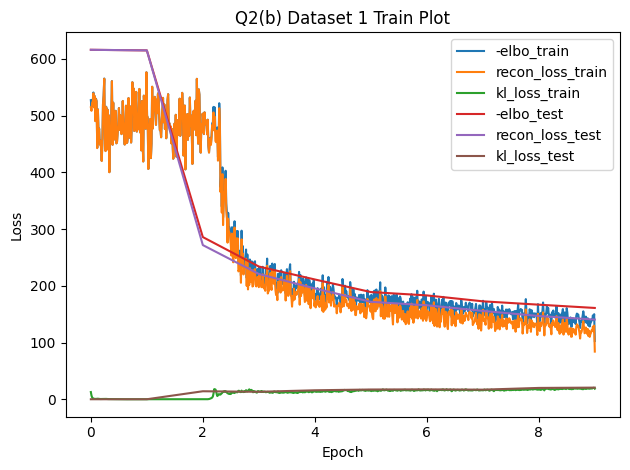

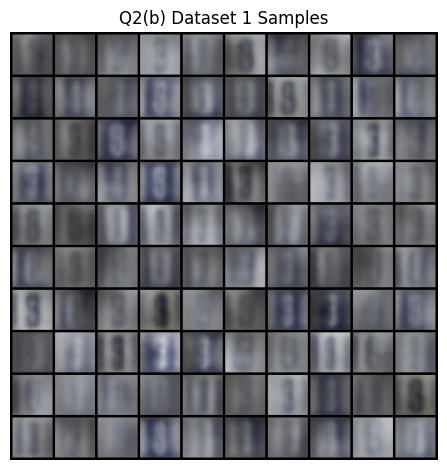

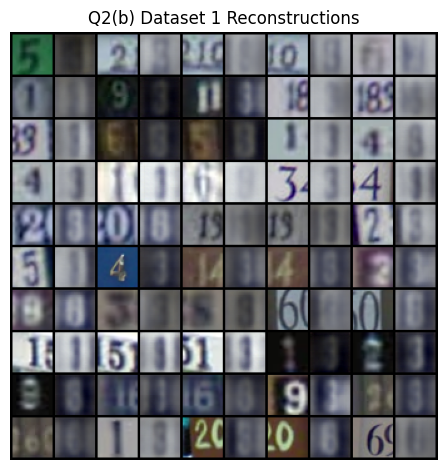

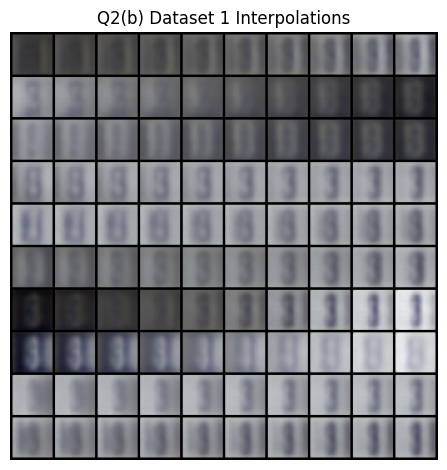

In [92]:
q2_save_results('b', 1, q2_b)

Epoch 0, loss 327.5779, recon_loss 304.0421, kl_loss 23.5358: 100%|██████████| 50000/50000 [00:20<00:00, 2387.45it/s]


Test , loss 329.2795, recon_loss 305.7686, kl_loss 23.5108


Epoch 1, loss 275.9616, recon_loss 250.8792, kl_loss 25.0824: 100%|██████████| 50000/50000 [00:20<00:00, 2417.82it/s]


Test , loss 272.2759, recon_loss 246.7534, kl_loss 25.5225


Epoch 2, loss 239.1510, recon_loss 213.5295, kl_loss 25.6215: 100%|██████████| 50000/50000 [00:20<00:00, 2470.45it/s]


Test , loss 235.4057, recon_loss 209.5437, kl_loss 25.8620


Epoch 3, loss 225.1998, recon_loss 198.9467, kl_loss 26.2531: 100%|██████████| 50000/50000 [00:20<00:00, 2457.73it/s]


Test , loss 222.7989, recon_loss 196.2237, kl_loss 26.5752


Epoch 4, loss 211.6215, recon_loss 183.6977, kl_loss 27.9238: 100%|██████████| 50000/50000 [00:20<00:00, 2434.43it/s]


Test , loss 208.4333, recon_loss 181.0468, kl_loss 27.3865


Epoch 5, loss 202.4252, recon_loss 173.8302, kl_loss 28.5949: 100%|██████████| 50000/50000 [00:20<00:00, 2433.18it/s]


Test , loss 201.3467, recon_loss 172.6760, kl_loss 28.6707


Epoch 6, loss 199.4844, recon_loss 170.7961, kl_loss 28.6883: 100%|██████████| 50000/50000 [00:20<00:00, 2435.87it/s]


Test , loss 200.8852, recon_loss 171.9791, kl_loss 28.9061


Epoch 7, loss 197.9266, recon_loss 169.1520, kl_loss 28.7746: 100%|██████████| 50000/50000 [00:20<00:00, 2428.83it/s]


Test , loss 201.0290, recon_loss 171.6666, kl_loss 29.3624


Epoch 8, loss 195.0144, recon_loss 165.5766, kl_loss 29.4377: 100%|██████████| 50000/50000 [00:20<00:00, 2426.89it/s]


Test , loss 194.5366, recon_loss 164.6318, kl_loss 29.9049


Epoch 9, loss 191.1880, recon_loss 161.4281, kl_loss 29.7600: 100%|██████████| 50000/50000 [00:20<00:00, 2432.98it/s]


Test , loss 192.7720, recon_loss 162.7739, kl_loss 29.9981


Epoch 10, loss 187.8360, recon_loss 157.5056, kl_loss 30.3303: 100%|██████████| 50000/50000 [00:20<00:00, 2434.36it/s]


Test , loss 191.9888, recon_loss 162.3219, kl_loss 29.6669


Epoch 11, loss 188.1930, recon_loss 157.5892, kl_loss 30.6038: 100%|██████████| 50000/50000 [00:20<00:00, 2428.18it/s]


Test , loss 189.0991, recon_loss 159.1511, kl_loss 29.9480


Epoch 12, loss 187.4534, recon_loss 156.4805, kl_loss 30.9729: 100%|██████████| 50000/50000 [00:20<00:00, 2440.30it/s]


Test , loss 186.2969, recon_loss 155.2779, kl_loss 31.0190


Epoch 13, loss 183.6164, recon_loss 152.3227, kl_loss 31.2937: 100%|██████████| 50000/50000 [00:20<00:00, 2429.95it/s]


Test , loss 184.0772, recon_loss 152.5580, kl_loss 31.5192


Epoch 14, loss 183.2026, recon_loss 151.4696, kl_loss 31.7331: 100%|██████████| 50000/50000 [00:20<00:00, 2433.66it/s]


Test , loss 183.2174, recon_loss 151.6733, kl_loss 31.5441


Epoch 15, loss 182.4681, recon_loss 150.1342, kl_loss 32.3339: 100%|██████████| 50000/50000 [00:20<00:00, 2434.41it/s]


Test , loss 180.9330, recon_loss 148.2422, kl_loss 32.6908


Epoch 16, loss 181.8070, recon_loss 148.9094, kl_loss 32.8976: 100%|██████████| 50000/50000 [00:20<00:00, 2435.28it/s]


Test , loss 182.7503, recon_loss 149.7170, kl_loss 33.0333


Epoch 17, loss 176.8199, recon_loss 143.6627, kl_loss 33.1572: 100%|██████████| 50000/50000 [00:20<00:00, 2431.35it/s]


Test , loss 178.4829, recon_loss 145.1653, kl_loss 33.3176


Epoch 18, loss 178.6507, recon_loss 145.0474, kl_loss 33.6032: 100%|██████████| 50000/50000 [00:20<00:00, 2426.23it/s]


Test , loss 177.1222, recon_loss 143.9732, kl_loss 33.1490


Epoch 19, loss 177.8493, recon_loss 144.0577, kl_loss 33.7915: 100%|██████████| 50000/50000 [00:20<00:00, 2429.91it/s]


Test , loss 179.1435, recon_loss 146.1937, kl_loss 32.9498


Epoch 20, loss 173.9530, recon_loss 140.0189, kl_loss 33.9342: 100%|██████████| 50000/50000 [00:20<00:00, 2435.23it/s]


Test , loss 174.5936, recon_loss 140.8972, kl_loss 33.6963


Epoch 21, loss 173.3574, recon_loss 139.0841, kl_loss 34.2733: 100%|██████████| 50000/50000 [00:20<00:00, 2433.68it/s]


Test , loss 173.4193, recon_loss 139.3401, kl_loss 34.0793


Epoch 22, loss 171.2036, recon_loss 136.6325, kl_loss 34.5711: 100%|██████████| 50000/50000 [00:20<00:00, 2433.74it/s]


Test , loss 171.5993, recon_loss 137.4483, kl_loss 34.1510


Epoch 23, loss 169.7396, recon_loss 134.8412, kl_loss 34.8983: 100%|██████████| 50000/50000 [00:20<00:00, 2447.25it/s]


Test , loss 169.9676, recon_loss 135.3593, kl_loss 34.6083


Epoch 24, loss 170.5367, recon_loss 135.2513, kl_loss 35.2854: 100%|██████████| 50000/50000 [00:20<00:00, 2445.81it/s]


Test , loss 171.7708, recon_loss 135.7252, kl_loss 36.0456


Epoch 25, loss 168.9904, recon_loss 133.5517, kl_loss 35.4386: 100%|██████████| 50000/50000 [00:20<00:00, 2439.66it/s]


Test , loss 168.3892, recon_loss 133.6606, kl_loss 34.7286


Epoch 26, loss 167.4719, recon_loss 131.9518, kl_loss 35.5201: 100%|██████████| 50000/50000 [00:20<00:00, 2440.94it/s]


Test , loss 168.9390, recon_loss 133.3642, kl_loss 35.5747


Epoch 27, loss 166.3094, recon_loss 130.7857, kl_loss 35.5237: 100%|██████████| 50000/50000 [00:20<00:00, 2458.91it/s]


Test , loss 166.8193, recon_loss 130.9039, kl_loss 35.9154


Epoch 28, loss 165.6150, recon_loss 129.8328, kl_loss 35.7822: 100%|██████████| 50000/50000 [00:20<00:00, 2445.04it/s]


Test , loss 166.5841, recon_loss 131.1996, kl_loss 35.3845


Epoch 29, loss 165.5143, recon_loss 129.4495, kl_loss 36.0648: 100%|██████████| 50000/50000 [00:20<00:00, 2450.87it/s]


Test , loss 165.8923, recon_loss 129.8984, kl_loss 35.9939


Epoch 30, loss 165.4860, recon_loss 129.1701, kl_loss 36.3159: 100%|██████████| 50000/50000 [00:20<00:00, 2454.07it/s]


Test , loss 164.9198, recon_loss 128.4662, kl_loss 36.4536


Epoch 31, loss 164.9335, recon_loss 128.3915, kl_loss 36.5420: 100%|██████████| 50000/50000 [00:20<00:00, 2458.05it/s]


Test , loss 170.0321, recon_loss 133.2030, kl_loss 36.8291


Epoch 32, loss 163.3556, recon_loss 126.6223, kl_loss 36.7333: 100%|██████████| 50000/50000 [00:20<00:00, 2456.86it/s]


Test , loss 167.1641, recon_loss 130.7137, kl_loss 36.4504


Epoch 33, loss 165.3376, recon_loss 128.4581, kl_loss 36.8795: 100%|██████████| 50000/50000 [00:20<00:00, 2449.86it/s]


Test , loss 163.8265, recon_loss 126.7840, kl_loss 37.0425


Epoch 34, loss 164.9552, recon_loss 128.1570, kl_loss 36.7982: 100%|██████████| 50000/50000 [00:20<00:00, 2457.00it/s]


Test , loss 163.6338, recon_loss 127.1255, kl_loss 36.5083


Epoch 35, loss 162.4298, recon_loss 125.7611, kl_loss 36.6687: 100%|██████████| 50000/50000 [00:20<00:00, 2450.46it/s]


Test , loss 167.1931, recon_loss 130.2736, kl_loss 36.9196


Epoch 36, loss 162.0367, recon_loss 125.3174, kl_loss 36.7193: 100%|██████████| 50000/50000 [00:20<00:00, 2450.64it/s]


Test , loss 163.0480, recon_loss 127.0343, kl_loss 36.0138


Epoch 37, loss 163.2157, recon_loss 126.4563, kl_loss 36.7595: 100%|██████████| 50000/50000 [00:20<00:00, 2457.72it/s]


Test , loss 162.9219, recon_loss 125.5157, kl_loss 37.4062


Epoch 38, loss 164.0810, recon_loss 127.3505, kl_loss 36.7305: 100%|██████████| 50000/50000 [00:20<00:00, 2457.41it/s]


Test , loss 172.2783, recon_loss 134.9942, kl_loss 37.2841


Epoch 39, loss 161.7787, recon_loss 125.0822, kl_loss 36.6965: 100%|██████████| 50000/50000 [00:20<00:00, 2449.71it/s]


Test , loss 162.5652, recon_loss 126.1784, kl_loss 36.3868


Epoch 40, loss 161.0493, recon_loss 124.3253, kl_loss 36.7240: 100%|██████████| 50000/50000 [00:20<00:00, 2454.25it/s]


Test , loss 163.1908, recon_loss 126.4494, kl_loss 36.7414


Epoch 41, loss 162.0107, recon_loss 125.2916, kl_loss 36.7191: 100%|██████████| 50000/50000 [00:20<00:00, 2461.64it/s]


Test , loss 163.0785, recon_loss 127.0096, kl_loss 36.0690


Epoch 42, loss 160.5613, recon_loss 123.9354, kl_loss 36.6259: 100%|██████████| 50000/50000 [00:20<00:00, 2457.12it/s]


Test , loss 163.1855, recon_loss 127.2013, kl_loss 35.9842


Epoch 43, loss 161.9919, recon_loss 125.2682, kl_loss 36.7237: 100%|██████████| 50000/50000 [00:20<00:00, 2455.93it/s]


Test , loss 162.4310, recon_loss 125.1227, kl_loss 37.3083


Epoch 44, loss 160.3885, recon_loss 123.7378, kl_loss 36.6506: 100%|██████████| 50000/50000 [00:20<00:00, 2457.56it/s]


Test , loss 162.1958, recon_loss 125.1008, kl_loss 37.0950


Epoch 45, loss 161.7719, recon_loss 124.9152, kl_loss 36.8567: 100%|██████████| 50000/50000 [00:20<00:00, 2449.13it/s]


Test , loss 163.8005, recon_loss 126.4562, kl_loss 37.3443


Epoch 46, loss 160.4022, recon_loss 123.8477, kl_loss 36.5545: 100%|██████████| 50000/50000 [00:20<00:00, 2444.27it/s]


Test , loss 164.8531, recon_loss 128.5857, kl_loss 36.2674


Epoch 47, loss 160.0593, recon_loss 123.3241, kl_loss 36.7353: 100%|██████████| 50000/50000 [00:20<00:00, 2440.01it/s]


Test , loss 162.3898, recon_loss 125.7315, kl_loss 36.6583


Epoch 48, loss 161.4717, recon_loss 124.4819, kl_loss 36.9898: 100%|██████████| 50000/50000 [00:20<00:00, 2456.52it/s]


Test , loss 162.6368, recon_loss 126.1001, kl_loss 36.5368


Epoch 49, loss 161.4976, recon_loss 124.7945, kl_loss 36.7030: 100%|██████████| 50000/50000 [00:20<00:00, 2471.60it/s]


Test , loss 163.3141, recon_loss 126.5719, kl_loss 36.7422
Final -ELBO: 163.3141, Recon Loss: 126.5719, KL Loss: 36.7422


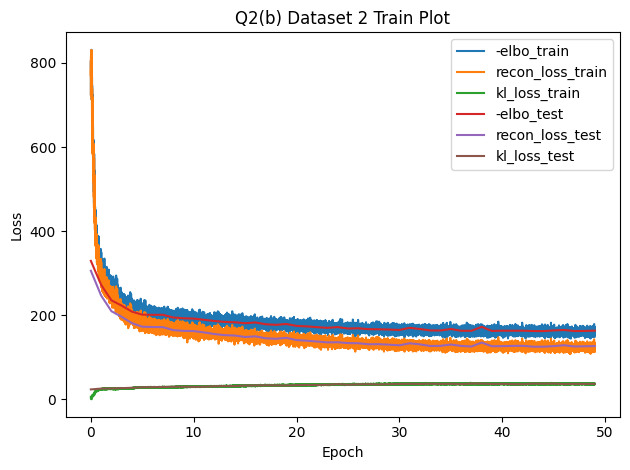

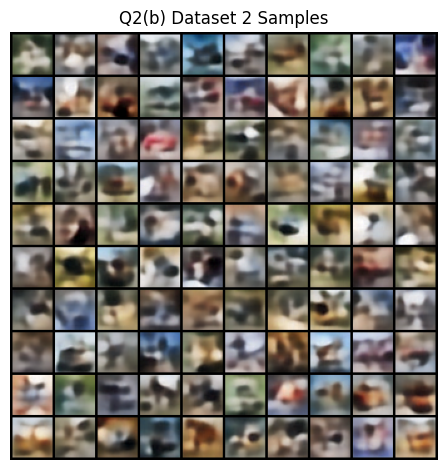

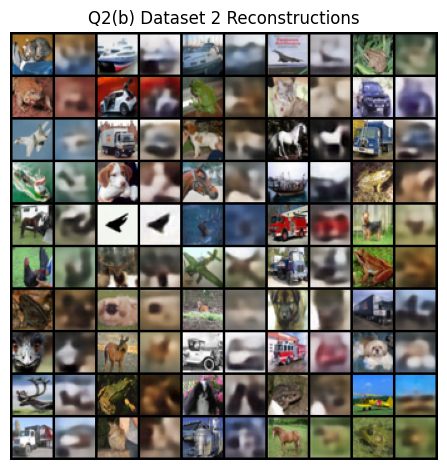

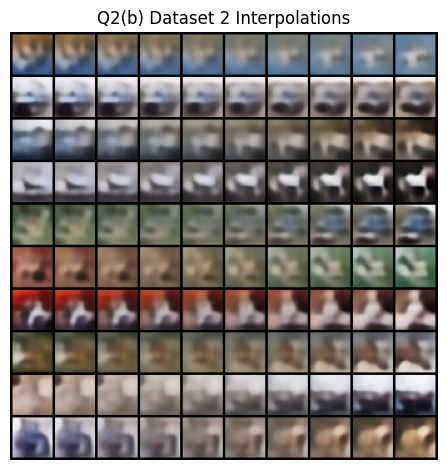

In [87]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )

    def forward(self, x):
        return x + self.net(x)

class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

class Quantize(nn.Module):

    def __init__(self, size, code_dim):
        super().__init__()
        self.embedding = nn.Embedding(size, code_dim)
        self.embedding.weight.data.uniform_(-1./size,1./size)

        self.code_dim = code_dim
        self.size = size

    def forward(self, z):
        b, c, h, w = z.shape
        weight = self.embedding.weight

        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.code_dim)
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
                    - 2 * torch.mm(flat_inputs, weight.t()) \
                    + (weight.t() ** 2).sum(dim=0, keepdim=True)
        encoding_indices = torch.max(-distances, dim=1)[1]
        encoding_indices = encoding_indices.view(b, h, w)
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, (quantized - z).detach() + z, encoding_indices


class VectorQuantizedVAE(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_size = code_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            ResidualBlock(256),
            ResidualBlock(256),
        )

        self.codebook = Quantize(code_size, code_dim)

        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode_code(self, x):
        with torch.no_grad():
            x = 2 * x - 1
            z = self.encoder(x)
            indices = self.codebook(z)[2]
            return indices

    def decode_code(self, latents):
        with torch.no_grad():
            latents = self.codebook.embedding(latents).permute(0, 3, 1, 2).contiguous()
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def forward(self, x):
        z = self.encoder(x)
        e, e_st, _ = self.codebook(z)
        x_tilde = self.decoder(e_st)

        diff1 = torch.mean((z - e.detach()) ** 2)
        diff2 = torch.mean((e - z.detach()) ** 2)
        return x_tilde, diff1 + diff2

    def loss(self, x):
        x = 2 * x - 1
        x_tilde, diff = self(x)
        recon_loss = F.mse_loss(x_tilde, x)
        loss = recon_loss + diff
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=diff)

In [16]:
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F


@dataclass
class TransformerConfig:
    vocab_size: int
    block_size: int
    model_type: str = "gpt"
    n_layer: int = 2
    n_head: int = 4
    n_embd: int = 128
    embd_pdrop: float = 0.0
    resid_pdrop: float = 0.0
    attn_pdrop: float = 0.0
    use_start_of_sequence_token: bool = False


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        (
            B,
            T,
            C,
        ) = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(
            dict(
                c_fc=nn.Linear(config.n_embd, 4 * config.n_embd),
                c_proj=nn.Linear(4 * config.n_embd, config.n_embd),
                act=nn.GELU(),
                dropout=nn.Dropout(config.resid_pdrop),
            )
        )
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))  # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x


class Transformer(nn.Module):
    """GPT Language Model"""

    def __init__(self, config: TransformerConfig):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size
        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                drop=nn.Dropout(config.embd_pdrop),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=nn.LayerNorm(config.n_embd),
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        if config.use_start_of_sequence_token:
            self.start_of_sequence_token = nn.Parameter(torch.randn(1, 1, config.n_embd))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params / 1e6,))

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert (
            t <= self.block_size
        ), f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        if t != 0:
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(
                0
            )  # shape (1, t)

            # forward the GPT model itself
            tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
            pos_emb = self.transformer.wpe(
                pos
            )  # position embeddings of shape (1, t, n_embd)
            x = self.transformer.drop(tok_emb + pos_emb)
        else:
            x = None

        # append start of sequence token if applicable to the start
        if hasattr(self, "start_of_sequence_token"):
            sos_emb = self.start_of_sequence_token.expand(b, 1, -1)
            if x is None:
                x = sos_emb
            else:
                x = torch.cat((sos_emb, x), dim=1)

            if x.shape[1] > self.block_size:
                x = x [:, :self.block_size, :]

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        return logits

    def loss(self, x):
        """Calculate the loss on some input data"""
        if hasattr(self, "start_of_sequence_token"):
            x_in, targets = x, x
        else:
            x_in, targets = x[:, :-1], x[:, 1:]

        logits = self(x_in)

        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-1
        )
        return OrderedDict(loss=loss)

    @torch.no_grad()
    def generate(
        self, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None
    ):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        import time
        time_list = []
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = (
                idx if idx.size(1) <= self.block_size else idx[:, -self.block_size :]
            )
            # forward the model to get the logits for the index in the sequence
            start_time = time.time()
            logits = self(idx_cond)
            time_list.append(time.time() - start_time)

            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("Inf")
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, time_list

In [42]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')

    code_dim, code_size = 256, 128
    vqvae = VectorQuantizedVAE(code_dim, code_size).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(vqvae, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3, grad_clip=1), quiet=True)
    vqvae_train_losses, vqvae_test_losses = train_losses['loss'], test_losses['loss']

    def create_prior_dataset(data_loader):
        prior_data = []
        with torch.no_grad():
            for x in data_loader:
                x = x.cuda()
                z = vqvae.encode_code(x)
                prior_data.append(z.long())
        return torch.cat(prior_data, dim=0)

    prior_train_data, prior_test_data = create_prior_dataset(train_loader), create_prior_dataset(test_loader) # [batch, 8, 8]. Int in 128.

    H, W = 8, 8
    tf_config = TransformerConfig(
        vocab_size=128,
        block_size=H * W,
        use_start_of_sequence_token=True,
    )
    model = Transformer(tf_config).cuda()
    prior_train_data = torch.tensor(prior_train_data).contiguous().view(-1, H * W).long()
    prior_test_data = torch.tensor(prior_test_data).contiguous().view(-1, H * W).long()

    prior_train_loader = data.DataLoader(prior_train_data, batch_size=64, shuffle=True)
    prior_test_loader = data.DataLoader(prior_test_data, batch_size=64)

    train_args = dict(epochs=20, lr=3e-4, grad_clip=1, use_cos_decay=True, warmup=1000)
    prior_train_losses, prior_test_losses = train_epochs(model, prior_train_loader, prior_test_loader, train_args)

    idx = torch.ones(100, 0).long().cuda()
    generated, _ =  model.generate(
        idx,
        64,
        temperature=1,
        do_sample=True,
    ) # generated is of shape (b, t+1) so exclude leading token
    samples = generated.reshape((-1, 8, 8))
    samples = vqvae.decode_code(samples) * 255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z = vqvae.encode_code(x)
        x_recon = vqvae.decode_code(z)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    print(prior_test_losses)
    return vqvae_train_losses, vqvae_test_losses, prior_train_losses['loss'], prior_test_losses['loss'], samples, reconstructions

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

<ipython-input-42-bf72a74dd1dc>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prior_train_data = torch.tensor(prior_train_data).contiguous().view(-1, H * W).long()
<ipython-input-42-bf72a74dd1dc>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prior_test_data = torch.tensor(prior_test_data).contiguous().view(-1, H * W).long()


number of parameters: 0.42M


Epoch 0, loss 2.9201: 100%|██████████| 10000/10000 [00:01<00:00, 5497.89it/s]


Test , loss 2.7012


Epoch 1, loss 2.5360: 100%|██████████| 10000/10000 [00:01<00:00, 5566.42it/s]


Test , loss 2.3700


Epoch 2, loss 2.3763: 100%|██████████| 10000/10000 [00:01<00:00, 6368.57it/s]


Test , loss 2.2503


Epoch 3, loss 2.3153: 100%|██████████| 10000/10000 [00:01<00:00, 6374.68it/s]


Test , loss 2.1931


Epoch 4, loss 2.2619: 100%|██████████| 10000/10000 [00:01<00:00, 6317.64it/s]


Test , loss 2.1580


Epoch 5, loss 2.2467: 100%|██████████| 10000/10000 [00:01<00:00, 6222.59it/s]


Test , loss 2.1295


Epoch 6, loss 2.1906: 100%|██████████| 10000/10000 [00:01<00:00, 6185.96it/s]


Test , loss 2.1053


Epoch 7, loss 2.1797: 100%|██████████| 10000/10000 [00:02<00:00, 4844.77it/s]


Test , loss 2.0861


Epoch 8, loss 2.1431: 100%|██████████| 10000/10000 [00:01<00:00, 6058.66it/s]


Test , loss 2.0763


Epoch 9, loss 2.1399: 100%|██████████| 10000/10000 [00:01<00:00, 6247.61it/s]


Test , loss 2.0721


Epoch 10, loss 2.1248: 100%|██████████| 10000/10000 [00:01<00:00, 6021.80it/s]


Test , loss 2.0530


Epoch 11, loss 2.1118: 100%|██████████| 10000/10000 [00:01<00:00, 6260.64it/s]


Test , loss 2.0501


Epoch 12, loss 2.0894: 100%|██████████| 10000/10000 [00:01<00:00, 6274.20it/s]


Test , loss 2.0424


Epoch 13, loss 2.0927: 100%|██████████| 10000/10000 [00:02<00:00, 4997.94it/s]


Test , loss 2.0364


Epoch 14, loss 2.0770: 100%|██████████| 10000/10000 [00:01<00:00, 5674.79it/s]


Test , loss 2.0303


Epoch 15, loss 2.0653: 100%|██████████| 10000/10000 [00:01<00:00, 6249.77it/s]


Test , loss 2.0287


Epoch 16, loss 2.0676: 100%|██████████| 10000/10000 [00:01<00:00, 6258.65it/s]


Test , loss 2.0232


Epoch 17, loss 2.0470: 100%|██████████| 10000/10000 [00:01<00:00, 6223.79it/s]


Test , loss 2.0240


Epoch 18, loss 2.0575: 100%|██████████| 10000/10000 [00:01<00:00, 6246.45it/s]


Test , loss 2.0191


Epoch 19, loss 2.0487: 100%|██████████| 10000/10000 [00:01<00:00, 5592.62it/s]


Test , loss 2.0225
OrderedDict([('loss', [2.701164645385742, 2.369994630432129, 2.250304997253418, 2.193053276062012, 2.1579557525634767, 2.1294673236846924, 2.105345037460327, 2.0861029457092286, 2.0762651473999023, 2.07210161857605, 2.053002233505249, 2.050114743423462, 2.0423901027679445, 2.036388708496094, 2.030327046203613, 2.0287230167388914, 2.0231524658203126, 2.0239781764984133, 2.019115958404541, 2.0225113960266112])])
VQ-VAE Final Test Loss: 0.1748
PixelCNN Prior Final Test Loss: 2.0225


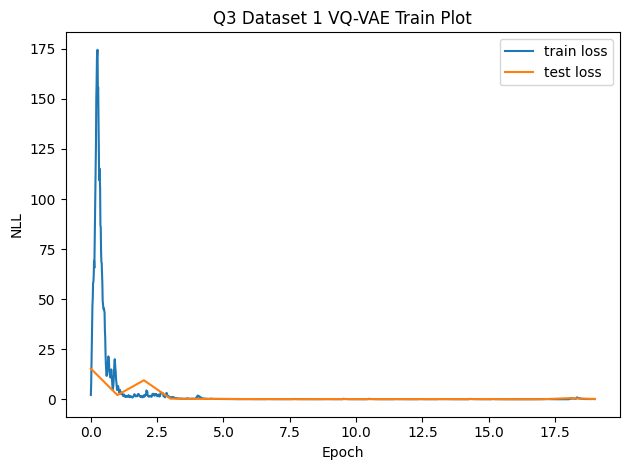

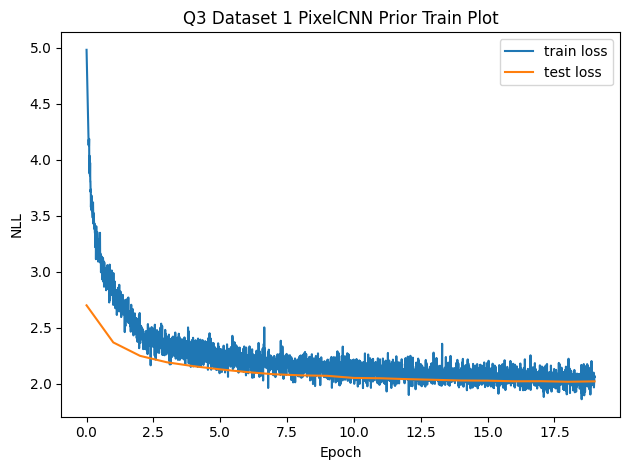

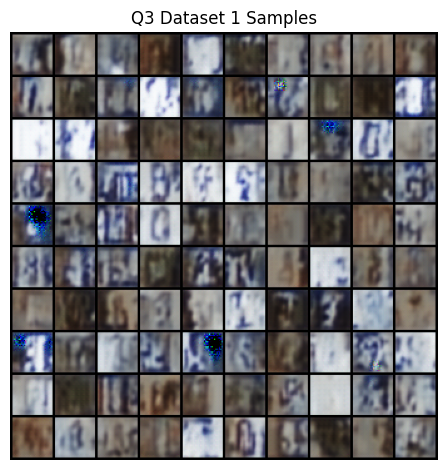

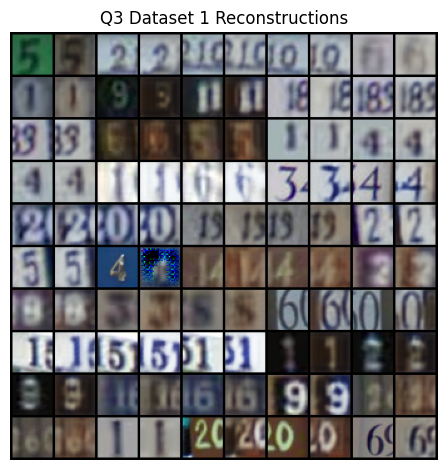

In [43]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)